In [3]:
import quspin as qs
import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.operators import quantum_operator
import math
from quspin.basis import spin_basis_general
from matplotlib import colors
import random
import time
import pickle
from scipy import signal

In [5]:
from numpy.fft  import fft2, ifft2
def np_fftconvolve(A, B):
    return np.real(ifft2(fft2(A)*fft2(B, s=A.shape)))

In [7]:
pulse_time = 0.0478e-3 # in s
free_time = 15000 * pulse_time # 0.6e-3 # in s
rabi_frequency = 2*np.pi*(1/pulse_time)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

0.9999999999999999


In [9]:
def intmatrix(Lx, J, xs=1, ys=1, theta=0, phi=0, Ly='_', plot=False):
    # define side length of simulated system as L
    if Lx % 2 == 1:
        pass
    else:
        Lx += 1

    if Ly == '_':
        Ly = Lx
    else:
        if Ly % 2 == 1:
            pass
        else:
            Ly += 1
    
    mat = np.zeros((Lx, Ly))
    
    L_xrange, L_yrange = range(Lx), range(Ly)
    center_xindex = int(L_xrange[-1]/2)
    center_yindex = int(L_yrange[-1]/2)
    
    
    center = np.array([xs*center_xindex, ys*center_yindex, 0]) #position of matrix center (in 3D)
    
    quan_axis = [np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)] #quantization axis as an unit vector
    
    
    for i in L_xrange:
        for j in L_yrange:
            displacement = np.array([xs*i, ys*j, 0]) - center
            r = np.linalg.norm(displacement)
            angle = np.arccos(displacement @ quan_axis/r)
            mat[i, j] = J*(1-3*(np.cos(angle)**2))/(r**3)
    mat[center_xindex, center_yindex] = 0.0

    if plot == True:
        fig, ax = plt.subplots()

        mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi)
        couplings = np.transpose(mat) #transpose to show x and y axis correctly (this will also switch x and y corrdinate ordering when indexing)

        cmap = plt.cm.RdBu
        ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

        for i in range(len(couplings)):
            for j in range(len(couplings[0])): 
                c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
                #c = '(' + str(j) + ', ' + str(i) + ')'
                    
                ax.text(j, i, str(c), va='center', ha='center')
    
    return mat, Lx, Ly #indexing interaction matrix is done with mat[x coordinate, y coordinate]

def ran_occupied_sites(N, x, y): #dimensions of simulated lattice and no of particles to distribute
    total_sites = int(x*y)

    # Randomize which lattice sites are occupied
    occupied_sites = []
    free_sites = list(range(total_sites))
    
    for i in range(N):
        ran = random.randint(0, total_sites-i-1)
        #print('random int = ' + str(ran))
        occupied_sites.append(free_sites.pop(ran))
        
    return sorted(occupied_sites) #returns ordered list of N unique numbers between 0 and the total sites - 1 inclusive

def couples(sites, pairs, interactions, xy='_'):
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #dimensions of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        
        couples.append([interactions[int_x - 1  + (p1 % int_x) - (p2 % int_x), int_y - 1 + (p1 // int_x) - (p2 // int_x)], i[0], i[1]]) 
    return couples

def pbc_couples(sites, pairs, interactions, xy='_'): #Constructs interaction strengths for periodic boundry conditions
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #centre of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        dx, dy = (p1 % int_x) - (p2 % int_x), (p1 // int_x) - (p2 // int_x)
        
        if dx >= int_x:
            dx = dx - len(interactions)
        elif dx <= -int_x:
            dx = dx + len(interactions)
            
        if dy >= int_y:
            dy = dy - len(interactions[0])
        elif dy <= -int_y:
            dy = dy + len(interactions[0])
        
        couples.append([interactions[int_x - 1  + dx, int_y - 1 + dy], i[0], i[1]]) 
    return couples

def symm_mat(x, y, occupied_sites, basis, axis=1): #defult finds mirror plane transformation which flips x coordinates
    #only relevent if lattice simulated has the symmetry which is tested on basis staes
    #occupied sites labelled left to right up to down in basis
    #for rectangular simulated systems (but sites occupied can be picked)

    symm = np.zeros((len(basis), len(basis)))
    count1 = 0
    asymmetrics = []
    flips = []
    for i in basis:
        basis_on_lattice = np.zeros((x, y))
        count2 = 0
        for n in i:
            if n == 1:
                basis_on_lattice[occupied_sites[count2] % x, occupied_sites[count2] // x] = 1

            count2 += 1

        flipped = np.flip(basis_on_lattice, axis)
        
        
        if flipped == basis_on_lattice:
            symm[count1, count1] = 1
        else:
            asymmetrics.append(basis_on_lattice)
            flips.append(flipped)
        count1 += 1

    for state in asymmetrics:
        pair = np.where(flips == state)[0]
        symm[pair[0], pair[1]], symm[pair[1], pair[0]] = 1, 1

    return symm
    
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def sparse_up_prob(L, row_len, col_len, populations): #col_len does nothing
    basis = spin_basis_general(N=L, pauli=False)
    #col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis, check_herm=False, check_symm=False, check_pcon=False))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = []
        for n in range(L):
            probs.append(outer_products[n].expt_value(i))
        results.append(sum(probs)/L)

    #print(results)
    return results

#define pulse sequences
def pulse_ramsey(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    elif t < pulse_time + free_time:
        return 0 
    elif t <= 2 * pulse_time + free_time:
        return rabi_frequency
    else:
        return 0

def pulse_single(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    else:
        return 0

def no_pulse(t, pulse_time, free_time, rabi_frequency):
    return 0

def construct_H(N, J, det, ax, ay, Lx, params, pulse, theta=0, phi=0, Ly='_', int_plot=False, occupied_sites='_', pbc=False):
    basis = spin_basis_general(N=N, pauli=False)
    #print(basis)
    if Ly == '_':
        Ly = 1

    #construct interaction
    sites = range(N)
    pairs = [[i, k] for idx, i in enumerate(sites) for k in sites[idx + 1:]]
    
    #interaction strengths between each particle
    interaction_matrix, _, _ = intmatrix(Lx*2 - 1, 1, xs=ax, ys=ay, theta=theta, phi=phi, Ly=Ly*2 - 1, plot=int_plot) 
    #above outputs 3 variables (also set J=1 in this function as it xJ at the end anyway) 

    #determin sites that are occupied (random or not)
    if type(occupied_sites) == str:
        sites = ran_occupied_sites(N, Lx, Ly)
    else:
        sites = sorted(occupied_sites) #make sure occupied sites is the correct length with numbers under total sites

    
    #contruct infomation in to reqired format
    if pbc == True: #For periodic boundry conditions
        intr = pbc_couples(sites, pairs, interaction_matrix)
    else:    
        intr = couples(sites, pairs, interaction_matrix)
    
    #construct resonant and detuning terms
    drive = [[1.0, i] for i in range(N)]
    detuning = [[1.0, i] for i in range(N)]

    operator_list_0 = [['z', detuning]]
    operator_list_1 = [['x', drive]]

    #print(intr)

    #construct full Hamiltonian
    interaction = [['+-', intr], ['-+', intr]]
    operator_dict = {'detuning': operator_list_0, 'drive': operator_list_1, 'interaction': interaction}
    H = quantum_operator(operator_dict, basis=basis, check_herm=False, check_symm=False, check_pcon=False)
    params_dict = dict(detuning=det, drive=(pulse, params), interaction=J)
    H_lmbda1 = H.tohamiltonian(params_dict)
    return H_lmbda1

def ensemble_Ramsey(samples, time, p_max, r_max, initial_state, N, J, det, ax, ay, params, pulse, theta=0, phi=0):
    results = []
    for i in range(samples):
        r = random.randint(0, int(3000*r_max/4))/1000
        p = p_max*(1 - (r/r_max)**2)
        side_length = int(np.sqrt(N/p))+1
        #print(side_length)
        #side_length = 2
        Hamiltonian = construct_H(N, J, det, ax, ay, side_length, params, pulse, theta=theta, phi=phi, Ly=side_length)
        populations = Hamiltonian.evolve(initial_state, 0, time)
        ups = sparse_up_prob(N, side_length, side_length, populations)
        results.append(ups[-1])
        #print('Sample ' + str(i) + ' completed')
    return sum(results)/samples

In [9]:
single_Ramsey_fringe = False
if single_Ramsey_fringe == True:
    start_time = time.time()

    intervals = 150
    holds = np.linspace(0, 300 * pulse_time, intervals)
    J = 1000
    L = 2
    row_len = L
    ax, ay = 1, 1
    
    psi_0 = np.zeros(2**L)
    psi_0[0] = 1 
    probs = []
    for free_time in holds:
        params = [pulse_time, free_time, rabi_frequency]
        H_lmb = construct_H(L, J, 0, ax, ay, row_len, params, pulse_ramsey)
        times = np.linspace(0, 2*pulse_time + free_time, 2)
        populations = H_lmb.evolve(psi_0, 0, times)
        #print(populations[0][-1])
        probs.append([abs(populations[0][-1])**2, abs(populations[1][-1])**2, abs(populations[2][-1])**2, abs(populations[3][-1])**2])
    print("--- %s seconds ---" % (time.time() - start_time))
    
    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    fig, axes = plt.subplots(1, 1)
    for i in range(2**L):
        axes.plot(holds*(10**3), [row[i] for row in probs], label='|' + labels[i] + r'$\rangle$')
        
        #for i in range(5):
            #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability", fontsize=20)
    axes.set_xlabel('Free evolution time (ms)', fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_ramsey.png', bbox_inches='tight')
    
    plt.show(block=False)
    

In [66]:
start_time = time.time()

intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)
samples = 1

particles_per_sample = 5
J, det, ax, ay = 1200, 0, 1, 1
p_max, r_max = 0.0544, 1000
theta, phi = 0, 0

initial_state = np.zeros(2**particles_per_sample)
initial_state[-1] = 1

up_probabilities = []
progress = 0
for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    times2 = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]
    up_probabilities.append(ensemble_Ramsey(samples, times2, p_max, r_max, initial_state, particles_per_sample, J, det, ax, ay, params, pulse_ramsey, theta=theta, phi=phi))
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_24704/2405997708.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


1/200 Done
2/200 Done
3/200 Done
4/200 Done
5/200 Done
6/200 Done
7/200 Done
8/200 Done
9/200 Done
10/200 Done
11/200 Done
12/200 Done
13/200 Done
14/200 Done
15/200 Done
16/200 Done
17/200 Done
18/200 Done
19/200 Done
20/200 Done
21/200 Done
22/200 Done
23/200 Done
24/200 Done
25/200 Done
26/200 Done
27/200 Done
28/200 Done
29/200 Done
30/200 Done
31/200 Done
32/200 Done
33/200 Done
34/200 Done
35/200 Done
36/200 Done
37/200 Done
38/200 Done
39/200 Done
40/200 Done
41/200 Done
42/200 Done
43/200 Done
44/200 Done
45/200 Done
46/200 Done
47/200 Done
48/200 Done
49/200 Done
50/200 Done
51/200 Done
52/200 Done
53/200 Done
54/200 Done
55/200 Done
56/200 Done
57/200 Done
58/200 Done
59/200 Done
60/200 Done
61/200 Done
62/200 Done
63/200 Done
64/200 Done
65/200 Done
66/200 Done
67/200 Done
68/200 Done
69/200 Done
70/200 Done
71/200 Done
72/200 Done
73/200 Done
74/200 Done
75/200 Done
76/200 Done
77/200 Done
78/200 Done
79/200 Done
80/200 Done
81/200 Done
82/200 Done
83/200 Done
84/200 Done
8

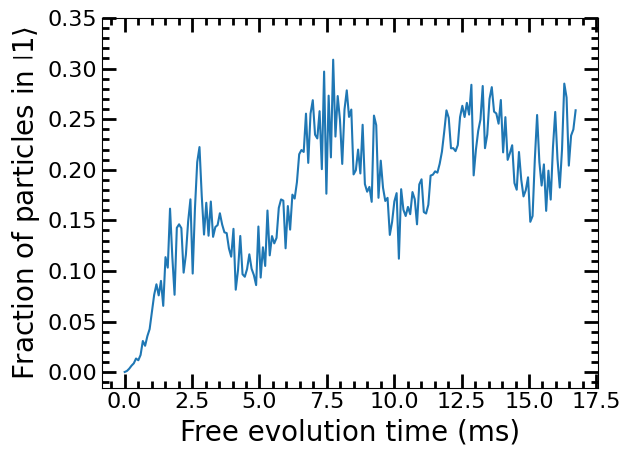

In [26]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
yticks = np.linspace(0, 0.35, 8)
axes.set_yticks(yticks) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'Ensemble_Ramsey_{particles_per_sample}_Particle_{samples}_samples_{J}Hz.png', bbox_inches='tight')
    
plt.show(block=False)

In [176]:
def generate_radial_distribution(lattice_filling_max, r_max):
    def generator_dist(r):
        return lattice_filling_max*(1 - (r/r_max)**2)
    return generator_dist

def generate_uniform_distribution(lattice_filling):
    def uniform_dist(r):
        return lattice_filling
    return uniform_dist

def prob_mat(function, lattice_dimensions, samples=1, ax=1, ay=1, polar=True):
    
    dist = np.zeros(lattice_dimensions)
    cen_x, cen_y = lattice_dimensions[0]/2, lattice_dimensions[1]/2
    
    cy = -cen_y
    for i in range(lattice_dimensions[1]):
        cx = -cen_x
        for n in range(lattice_dimensions[0]):
            sam_xpoints, sam_ypoints = np.linspace(cx - ax/2, cx + ax/2, samples + 1), np.linspace(cy - ay/2, cy + ay/2, samples + 1)

            if polar == True:
                values = []
                for u in sam_xpoints:
                    sam_radii = np.sqrt(u**2 + sam_ypoints**2)
                    values.append(function(sam_radii))
            ###################### next 'else' code is untested #####################
            else:
                values = []
                for u in sam_xpoints:
                    values.append(function(u, sam_ypoints))

            segments = 0
            for l in range(samples**2):
                avg_func = sum([values[ l % samples][ l // samples], values[ l % samples + 1][ l // samples], values[ l % samples][ l // samples + 1], values[ l % samples + 1][ l // samples + 1]])/4 
                segments += avg_func * (ax/samples) * (ay/samples)
            
            dist[n, i] = segments

            cx += ax
        cy += ay

    return dist

def unif_random_config(filling, N):
    side_length = int(np.sqrt(N/filling)) + 1
    positions = random.sample(range(1, side_length**2), N)
    config = np.zeros((side_length, side_length))
    for i in positions:
        config[i // side_length, i % side_length] = 1 
    return config

    

def unif_find_geometries(filling, N, samples):
    no = [[1]]
    pair = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
    diag_pair = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
    sep_pair = [[0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [0, 0, 0, 0, 0]]
    triangle = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
    chain_3 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
    chain_4 = [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

    particle_no, pair_no, diag_pair_no, sep_pair_no, triangle_no, chain_3_no, chain_4_no = [], [], [], [], [], [], []
    for i in range(samples):
        sample_config = unif_random_config(filling, N)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))
        particle_no.append(pattern_search(sample_config, no, symmetrical=True)/2)
        pair_no.append(2*pattern_search(sample_config, pair, symmetrical=True, particle_no=2)/N)
        diag_pair_no.append(2*pattern_search(sample_config, diag_pair, symmetrical=True, particle_no=2)/N)
        sep_pair_no.append(2*pattern_search(sample_config, sep_pair, symmetrical=True, particle_no=2)/N)
        triangle_no.append(3*pattern_search(sample_config, triangle, particle_no=3)/N)
        chain_3_no.append(3*pattern_search(sample_config, chain_3, symmetrical=True, particle_no=3)/N)
        chain_4_no.append(4*pattern_search(sample_config, chain_4, symmetrical=True, particle_no=4)/N)

    # returns list of averages and list of standard deviations
    return np.array([np.mean(particle_no), np.mean(pair_no), np.mean(diag_pair_no), np.mean(sep_pair_no), np.mean(triangle_no), np.mean(chain_3_no), np.mean(chain_4_no)]), [np.std(particle_no), np.std(pair_no), np.std(diag_pair_no), np.std(sep_pair_no), np.std(triangle_no), np.std(chain_3_no), np.std(chain_4_no)]

def unif_find_geometries(filling, N, samples):
    no = [[1]]
    pair = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
    diag_pair = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
    sep_pair = [[0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [0, 0, 0, 0, 0]]
    triangle = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
    chain_3 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
    chain_4 = [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

    particle_no, pair_no, diag_pair_no, sep_pair_no, triangle_no, chain_3_no, chain_4_no = [], [], [], [], [], [], []
    for i in range(samples):
        sample_config = unif_random_config(filling, N)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))
        particle_no.append(pattern_search(sample_config, no, symmetrical=True)/2)
        pair_no.append(2*pattern_search(sample_config, pair, symmetrical=True, particle_no=2)/N)
        diag_pair_no.append(2*pattern_search(sample_config, diag_pair, symmetrical=True, particle_no=2)/N)
        sep_pair_no.append(2*pattern_search(sample_config, sep_pair, symmetrical=True, particle_no=2)/N)
        triangle_no.append(3*pattern_search(sample_config, triangle, particle_no=3)/N)
        chain_3_no.append(3*pattern_search(sample_config, chain_3, symmetrical=True, particle_no=3)/N)
        chain_4_no.append(4*pattern_search(sample_config, chain_4, symmetrical=True, particle_no=4)/N)

    # returns list of averages and list of standard deviations
    return np.array([np.mean(particle_no), np.mean(pair_no), np.mean(diag_pair_no), np.mean(sep_pair_no), np.mean(triangle_no), np.mean(chain_3_no), np.mean(chain_4_no)]), [np.std(particle_no), np.std(pair_no), np.std(diag_pair_no), np.std(sep_pair_no), np.std(triangle_no), np.std(chain_3_no), np.std(chain_4_no)]
    
def config_freqs(configs, filling, N, samples):
    frequencies = []
    for i in range(samples):
        sample_config = unif_random_config(filling, N)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))

        instance = []
        for m in configs:
            found = 0
            particle_no = m[0].sum()
            for c in m:
                found += count_geometry(sample_config, c, particle_no=particle_no)
            instance.append(particle_no*found/N)
            #print(instance[-1])
        frequencies.append(instance)
    # returns list of averages and list of standard deviations
    return np.mean(frequencies, axis=0), np.std(frequencies, axis=0)

def count_geometry(image, kernel, particle_no='_'):
    kernel = np.array(kernel)
    m, n = kernel.shape
    if particle_no == '_':
        particle_no = m*n
        #print(particle_no)
    y, x = image.shape
    y = y - m + 1
    x = x - n + 1
    
    found = 0
    for i in range(y):
        for j in range(x):
            if (image[i:i+m, j:j+n] == kernel).all():
                found += 1
    return found

def count_geometry(image, kernel, particle_no='_'):
    #if particle_no == '_' :
        #particle_no = np.sum(kernel)
    kernel = np.select([kernel == 0], [-1], kernel)
    kernel = np.pad(kernel, ((1, 1), (1, 1)), 'constant', constant_values=((-1, -1), (-1, -1)))
    #print(kernel)
    g = signal.convolve2d(image, kernel)
    return np.count_nonzero(g == particle_no)

def find_geometry(image, kernel, particle_no='_'):
    #if particle_no == '_' :
        #particle_no = np.sum(kernel)
    kernel = np.select([kernel == 0], [-1], kernel)
    kernel = np.pad(kernel, ((1, 1), (1, 1)), 'constant', constant_values=((-1, -1), (-1, -1)))
    #print(kernel)
    g = signal.convolve2d(image, kernel, mode='same')
    g = np.select([g != particle_no], [0], g)
    g = np.select([g == particle_no], [1], g)
    return g

def rotated(array_2d):
    list_of_tuples = zip(*array_2d[::-1])
    return [list(elem) for elem in list_of_tuples]

def pattern_search(image, kernel, particle_no = '_', symmetrical=False):
    rot = 4
    if symmetrical == True:
        rot = 2
    patterns_found = 0
    for i in range(rot):
        patterns_found += count_geometry(image, kernel, particle_no=particle_no)
        kernel = rotated(kernel)
    return patterns_found

def random_config(discrete_dist):
    y, x = discrete_dist.shape
    config = np.zeros((y, x))
    for i in range(y):
        for n in range(x):
            roll = random.randint(0, 1000)/1000
            if roll <= discrete_dist[i, n]:
                config[i, n] = 1
    return config
            

In [239]:
for i in range(2):
    print('activated, no = ' + str(i))

activated, no = 0
activated, no = 1


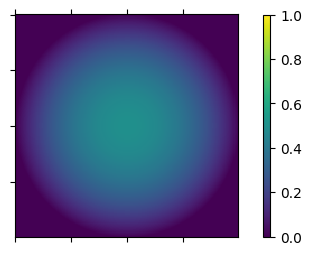

In [117]:
max_lattice_filling = 0.5
r_max = 100

distribution = generate_radial_distribution(max_lattice_filling, r_max)

result = prob_mat(distribution, (2*r_max, 2*r_max), samples=1, ax=1, ay=1, polar=True)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.matshow(result)
cax.set_clim(0, 1)
cbar = fig.colorbar(cax, location="right", 
        shrink=0.6,
        aspect=30,
        fraction=0.5)

plt.savefig(f'discrete_lattice_dist.pdf', bbox_inches='tight')

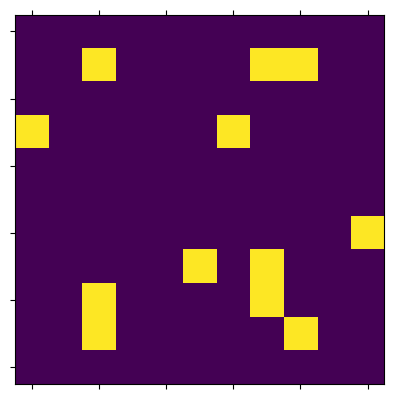

In [300]:
sample_config = unif_random_config(0.1, 12)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.matshow(sample_config)
cax.set_clim(0, 1)
# cbar = fig.colorbar(cax, location="right", 
#         shrink=0.6,
#         aspect=30,
#         fraction=0.5)
plt.savefig(f'12_particles6.pdf', bbox_inches='tight')

In [302]:
print(count_geometry(sample_config, np.array([[1, 1]]), particle_no=2))
print(count_geometry1(sample_config, [[1, 0], [0, 1]]))

1


NameError: name 'count_geometry1' is not defined

In [113]:
norm = 0
for i in sample_config:
    for n in i:
        norm += n

print('Number of particles: ' + str(norm))

no = [[1]]
pair = [[1, 1]]
diag_pair = [[1, 0], [0, 1]]
triangle = [[1, 1], [1, 0]]
chain_3 = [[1, 1, 1]]
chain_4 = [[1, 1, 1, 1]]

def find_geometries_old(discrete_dist, samples):
    no = [[1]]
    pair = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
    diag_pair = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
    triangle = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
    chain_3 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
    chain_4 = [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

    particle_no, pair_no, diag_pair_no, triangle_no, chain_3_no, chain_4_no = [], [], [], [], [], []
    for i in range(samples):
        sample_config = random_config(discrete_dist)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))
        particle_no.append(pattern_search(sample_config, no, symmetrical=True)/2)
        pair_no.append(pattern_search(sample_config, pair, symmetrical=True))
        diag_pair_no.append(pattern_search(sample_config, diag_pair, symmetrical=True, particle_no=2))
        triangle_no.append(pattern_search(sample_config, triangle, particle_no=3))
        chain_3_no.append(pattern_search(sample_config, chain_3, symmetrical=True, particle_no=3))
        chain_4_no.append(pattern_search(sample_config, chain_4, symmetrical=True))

    # returns list of averages and list of standard deviations
    return np.array([np.mean(particle_no), np.mean(pair_no), np.mean(diag_pair_no), np.mean(triangle_no), np.mean(chain_3_no), np.mean(chain_4_no)]), [np.std(particle_no), np.std(pair_no), np.std(diag_pair_no), np.std(triangle_no), np.std(chain_3_no), np.std(chain_4_no)]

averages, standard_deviations = unif_find_geometries(0.5, 12, 10)
print(averages)
print('Number of particles, Number of pairs, Number of diagonal pairs, Number of triangles, Number of 3 particle chains, Number of 4 particle chains')



Number of particles: 12.0
[12.  8.  8.  8. 36. 18. 32.]
Number of particles, Number of pairs, Number of diagonal pairs, Number of triangles, Number of 3 particle chains, Number of 4 particle chains


<ErrorbarContainer object of 3 artists>

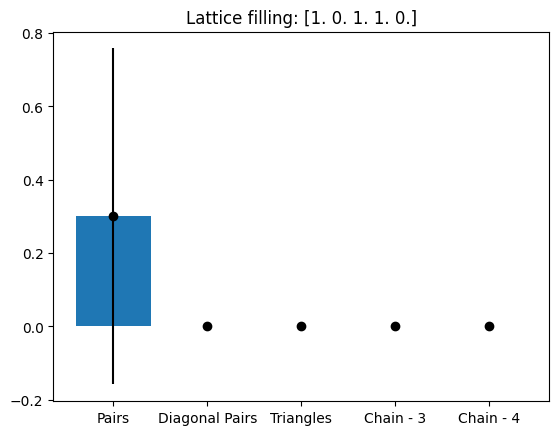

In [77]:
labels = ['Particle number', 'Pairs', 'Diagonal Pairs', 'Seperated Pairs', 'Triangles', 'Chain - 3', 'Chain - 4']

fig, ax = plt.subplots()
ax.set_title('Lattice filling: ' + str(i))
ax.bar(labels[1:], averages[1:])
ax.errorbar(labels[1:], averages[1:], yerr=standard_deviations[1:], color='black', fmt='o')

In [84]:
a = np.array([[1, 2, 3], 
     [4, 5, 6]])
print(a)
print(rotated(rotated(a)))
for i in range(4):
    print(i)

[[1 2 3]
 [4 5 6]]
[[np.int64(6), np.int64(5), np.int64(4)], [np.int64(3), np.int64(2), np.int64(1)]]
0
1
2
3


In [124]:
with open('Orbits.pickle', 'rb') as handle:
    orbits = pickle.load(handle)

In [120]:
lat_fils = np.linspace(0.001, 0.6, 100)
N_per_sample = 500
r_max = 100
iterations = 75


pair = [[np.array([[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]), np.array([[0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 0]])]]

h_pair_avg, h_pair_std = [], []
l_pair_avg, l_pair_std = [], []
for i in lat_fils:
        high_averages, high_standard_deviations = config_freqs(pair, i, 500, iterations)
        low_averages, low_standard_deviations = config_freqs(pair, i, 100, iterations)
        h_pair_avg.append(high_averages)
        h_pair_std.append(high_standard_deviations)
        l_pair_avg.append(low_averages)
        l_pair_std.append(low_standard_deviations)
        #print('Done: ' + str(i))

h_pair_avg, h_pair_std = np.array(h_pair_avg), np.array(h_pair_std)
l_pair_avg, l_pair_std = np.array(l_pair_avg), np.array(l_pair_std)
h_pair_avg, h_pair_std = np.transpose(h_pair_avg)[0], np.transpose(h_pair_std)[0]
l_pair_avg, l_pair_std = np.transpose(l_pair_avg)[0], np.transpose(l_pair_std)[0]


(0.0, 0.6)

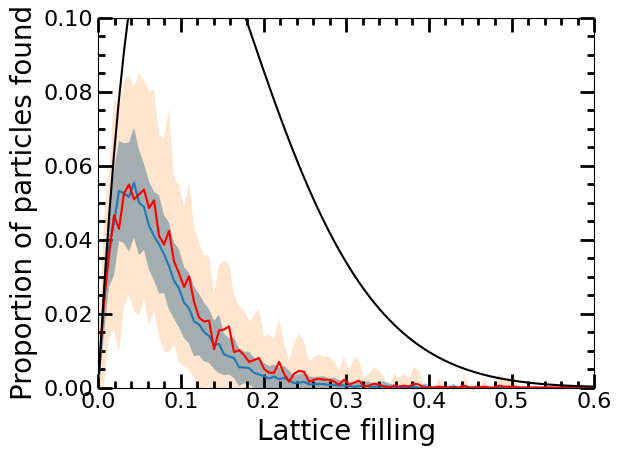

In [121]:
fig, axes = plt.subplots(1, 1)


axes.plot(lat_fils, h_pair_avg)
axes.fill_between(lat_fils, h_pair_avg-h_pair_std, h_pair_avg+h_pair_std, alpha=0.5)  

axes.plot(lat_fils, l_pair_avg, color='red')
axes.fill_between(lat_fils, l_pair_avg-l_pair_std, l_pair_avg+l_pair_std, alpha=0.2)  

def func(x):
    return 4*x*((1-x)**10)

axes.plot(lat_fils, func(lat_fils), color='black')

axes.set_xlabel(r"Lattice filling", fontsize=20)
axes.set_ylabel('Proportion of particles found', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
axes.set_ylim([0, 0.1])
axes.set_xlim([0, 0.6])


#print(np.transpose(all_avg))

In [126]:
lat_fils = np.linspace(0.001, 0.6, 100)
N_per_sample = 1000
r_max = 100
iterations = 75



orbits.append([np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])])

all_avg0, all_std0 = [], []
for i in lat_fils:
        averages, standard_deviations = config_freqs(orbits, i, N_per_sample, iterations)
        all_avg0.append(averages)
        all_std0.append(standard_deviations)
        print('Done: ' + str(i))



all_avg, all_std = np.transpose(np.array(all_avg0)), np.transpose(np.array(all_std0))


#print(np.transpose(all_avg))

Done: 0.001
Done: 0.00705050505050505
Done: 0.0131010101010101
Done: 0.019151515151515152
Done: 0.0252020202020202
Done: 0.03125252525252525
Done: 0.0373030303030303
Done: 0.04335353535353535
Done: 0.0494040404040404
Done: 0.05545454545454545
Done: 0.0615050505050505
Done: 0.06755555555555555
Done: 0.0736060606060606
Done: 0.07965656565656565
Done: 0.0857070707070707
Done: 0.09175757575757575
Done: 0.0978080808080808
Done: 0.10385858585858586
Done: 0.1099090909090909
Done: 0.11595959595959596
Done: 0.122010101010101
Done: 0.12806060606060604
Done: 0.1341111111111111
Done: 0.14016161616161615
Done: 0.1462121212121212
Done: 0.15226262626262627
Done: 0.1583131313131313
Done: 0.16436363636363635
Done: 0.1704141414141414
Done: 0.17646464646464646
Done: 0.1825151515151515
Done: 0.18856565656565655
Done: 0.1946161616161616
Done: 0.20066666666666666
Done: 0.20671717171717172
Done: 0.21276767676767674
Done: 0.2188181818181818
Done: 0.22486868686868686
Done: 0.2309191919191919
Done: 0.2369696969

In [127]:
#correct for double counting

all_avg[66] = all_avg[66] - (2/3)*(all_avg[6] + all_avg[7]) - 2*(all_avg[8]) - (1/2)*(all_avg[14]) - (2/5)*(all_avg[38]) #seperated pair
all_avg[67] = all_avg[67] - (2/3)*(all_avg[12] + all_avg[76]) - (1/2)*(all_avg[14]) - (2/5)*(all_avg[39]) - all_avg[13] - all_avg[71] #pair
all_avg[68] = all_avg[68] - (3/4)*(all_avg[36] + all_avg[37]) - (3/5)*(all_avg[38] + all_avg[39]) - all_avg[40] #3 chain

all_avg, all_std = np.transpose(all_avg), np.transpose(all_std)

In [365]:
print(np.transpose(all_avg))
print(orbits[0:2])

[[0.         0.19333333 0.15333333 0.27333333 0.10666667 0.09333333
  0.1        0.06       0.1        0.04       0.01333333 0.02
  0.00666667 0.02       0.         0.         0.         0.
  0.         0.        ]
 [0.04       0.30666667 0.52666667 0.36666667 0.39333333 0.39333333
  0.23333333 0.18       0.12       0.08       0.05333333 0.02666667
  0.03333333 0.01333333 0.00666667 0.         0.         0.02
  0.00666667 0.        ]]
[array([[0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0.]]), array([[0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.]])]


In [244]:
#Make sure the lone particle appended on the end of orbits (andall_avg/all_std) is removed before uncommenting
with open('Sampled_frequencies.pickle', 'wb') as handle:
    pickle.dump([all_avg, all_std], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
from matplotlib import gridspec
import scipy.optimize
from scipy.special import factorial

def normal(x, vals):
        std = vals[1]*x + 0.05
        return vals[2]*np.exp(-(1/2)*((x-vals[0])/std)**2)

def fitted_curve(x, vals):
    return vals[0]*(np.tanh(vals[1]*x) + np.e**(-vals[2]*x) - 1)

def gen_fitted_curve(vals):
    def fitted_curve(x):
        return vals[0]*(np.tanh(vals[1]*x) + np.e**(-vals[2]*x) - 1)
    return fitted_curve
    
def gen_norm(vals):
    def nor(x):
        std = vals[1]*x + 0.05
        return vals[2]*np.exp(-(1/2)*((x-vals[0])/std)**2)
    return nor

def poisson(x, vals):                  #vals is mu then coefficient
    x = x*vals[3] + vals[2]
    return vals[1]*np.exp(-vals[0])*(vals[0]**x)/factorial(x)

def gen_poi(vals):
    def poi(x):                  #vals is mu then coefficient
        x = x*vals[3] + vals[2]
        return vals[1]*np.exp(-vals[0])*(vals[0]**x)/factorial(x)
    return poi

def gen_chisq(model_funct):
    def chi(modelparams, x_data, y_data, y_err):
        chisqval=0
        for i in range(len(x_data)):
            chisqval += ((y_data[i] - model_funct(x_data[i], modelparams))/y_err[i])**2
        return chisqval
    return chi

labels = ['Particle number', 'Pairs', 'Diagonal Pairs', 'Seperated Pairs', 'Triangles', 'Chain - 3', 'Chain - 4']
    
chisq = gen_chisq(fitted_curve)

In [204]:
def gen_pro(symm, parts, empty):
    def pro(lat_fil):
        return symm*((1 - lat_fil)**empty)*(lat_fil**(parts - 1))
    return pro

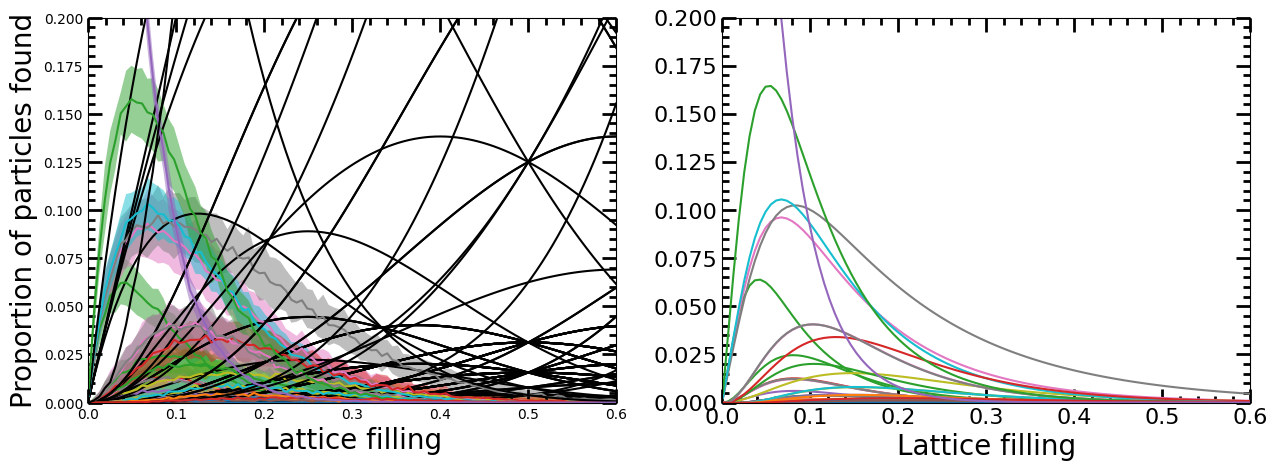

[0.         0.00117333 0.00314667 0.00746667 0.01053333 0.01866667
 0.02924    0.04064    0.05522667 0.06762667 0.0848     0.1034
 0.11985333 0.14069333 0.15921333 0.18344    0.20726667 0.23381333
 0.25938667 0.28936    0.30832    0.33293333 0.36072    0.38662667
 0.41726667 0.43445333 0.46698667 0.47982667 0.51366667 0.53254667
 0.55004    0.58285333 0.60992    0.62177333 0.64545333 0.66125333
 0.68186667 0.70590667 0.72886667 0.74308    0.74108    0.76668
 0.78230667 0.79837333 0.79624    0.81753333 0.83554667 0.8344
 0.84828    0.86821333 0.86568    0.88548    0.88458667 0.89884
 0.89904    0.9146     0.911      0.92365333 0.92565333 0.93549333
 0.93476    0.9458     0.94748    0.94794667 0.9548     0.95386667
 0.96225333 0.96266667 0.96414667 0.97052    0.97146667 0.96993333
 0.97673333 0.97776    0.97786667 0.98302667 0.98388    0.98326667
 0.98653333 0.98706667 0.98768    0.9882     0.99050667 0.99022667
 0.99076    0.98965333 0.99290667 0.99358667 0.99277333 0.99285333
 0.99588 

In [210]:
fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1])
axes = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
initial = np.array([0.5, 20, 15])
const_error = 0.01*np.ones(100)

coefficients = []
normalization = np.zeros(100)

leftover = np.ones(100)
count = 0
for ys, error in zip(np.transpose(all_avg), np.transpose(all_std)):
    geometry = orbits[count]
    symm = len(geometry)
    particles = geometry[0].sum()
    fy, fx = geometry[0].shape
    empty = fy*fx - particles
    
    pro = gen_pro(symm, particles, empty)
    prob_data = pro(lat_fils)
    axes.plot(lat_fils, prob_data, color='black')

    #ys, error = i, o
    normalization = normalization + ys
    axes.plot(lat_fils, ys)

    #for particles not counted
    leftover = leftover - ys
    
    axes.fill_between(lat_fils, ys-error, ys+error, alpha=0.5)    
    #for i in range(5):
        #print(populations[:,1][100*i])
    if True:
        fit = scipy.optimize.minimize(chisq, initial, args=(lat_fils, ys, const_error))
        #print(fit.message)
        #print(fit.x)
        coefficients.append(fit.x)
    
        model = gen_fitted_curve(fit.x)
        #model = gen_norm(initial)
        #print(model(0.12))
        modelled_data = model(lat_fils)
    
        ax2.plot(lat_fils, modelled_data)
    count += 1


axes.plot(lat_fils, leftover, color = 'black')

axes.set_xlabel(r"Lattice filling", fontsize=20)
ax2.set_xlabel(r"Lattice filling", fontsize=20)
axes.set_ylabel('Proportion of particles found', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
ax2.minorticks_on()
ax2.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
axes.set_ylim([0, 0.20])
ax2.set_ylim([0, 0.20])
axes.set_xlim([0, 0.6])
ax2.set_xlim([0, 0.6])


plt.savefig(f'freqs_graph_with_leftover.pdf', bbox_inches='tight')
plt.show(block=False)
print(leftover)

84


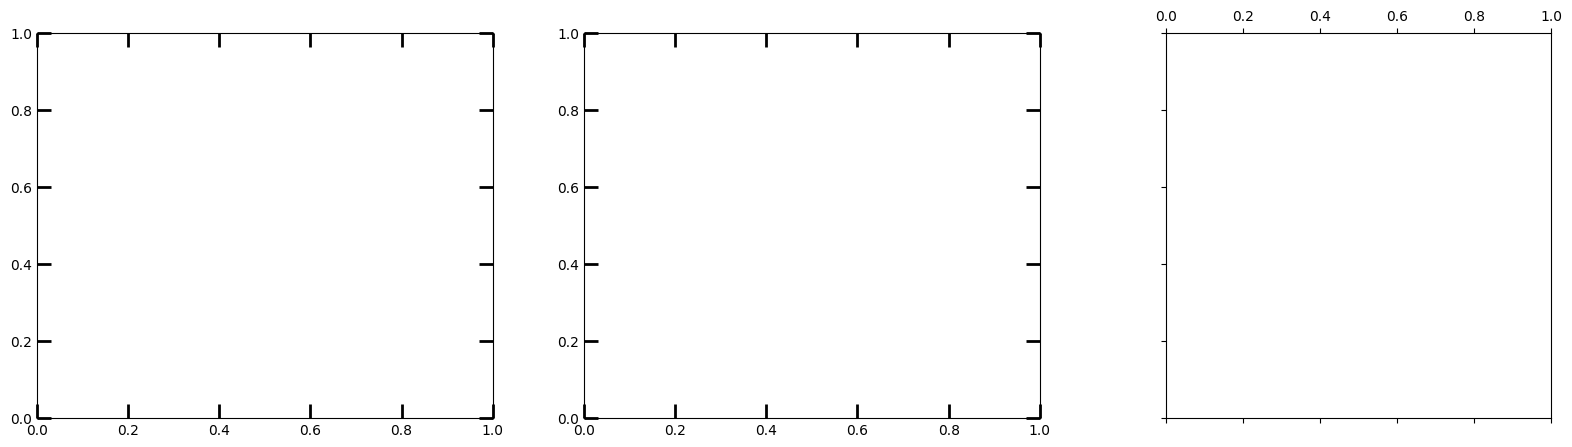

In [284]:
with open('Fitted_freq_coefficients.pickle', 'rb') as handle:
    model_coefficients = np.array(pickle.load(handle))
print(len(model_coefficients))
with open('Sampled_frequencies.pickle', 'rb') as handle:
    sampled_freqs = np.array(pickle.load(handle))

averages, standard_deviations = sampled_freqs

fig = plt.figure(figsize=(20, 5))
spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 1, 1])
axes = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
conax = fig.add_subplot(spec[2])

##### animation
from matplotlib.animation import PillowWriter

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=3, metadata=metadata)



with writer.saving(fig, f'frequencies.gif', len(orbits)):


    for configuration in range(len(orbits)):
        if np.max(np.transpose(averages)[configuration]) <= 0.01:
            continue
        
        count = 0
        for ys, error, model_params in zip(np.transpose(averages), np.transpose(standard_deviations), model_coefficients):


            #for i in range(5):
                #print(populations[:,1][100*i])
            model = gen_fitted_curve(model_params)
                #model = gen_norm(initial)
                #print(model(0.12))
            modelled_data = model(lat_fils)
            
            if count == configuration:
                opacity = 1
                axes.plot(lat_fils, ys, alpha=opacity)
                axes.fill_between(lat_fils, ys-error, ys+error, alpha=0.5) 
                ax2.plot(lat_fils, modelled_data, alpha=opacity)
            else:
                opacity = 0.2
                axes.plot(lat_fils, ys, alpha=opacity)
                #ax2.plot(lat_fils, modelled_data, alpha=opacity)
            #ys, error = i, o
        
            
        
            #for particles not counted
            
               
            
            
            
            count += 1
        
        
        axes.set_xlabel(r"Lattice filling", fontsize=20)
        ax2.set_xlabel(r"Lattice filling", fontsize=20)
        axes.set_ylabel('Proportion of particles found', fontsize=20)
        
        axes.minorticks_on()
        axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        ax2.minorticks_on()
        ax2.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        ax2.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        axes.set_ylim([0, 0.20])
        #ax2.set_ylim([0, 0.20])
        axes.set_xlim([0, 0.6])
        ax2.set_xlim([0, 0.6])

        cax = conax.matshow(orbits[configuration][-1])
        cax.set_clim(0, 1)
        # Hide X and Y axes label marks
        conax.xaxis.set_tick_params(labelbottom=False)
        conax.yaxis.set_tick_params(labelleft=False)
        
        # Hide X and Y axes tick marks
        conax.set_xticks([])
        conax.set_yticks([])


        
        writer.grab_frame()
        axes.clear()
        ax2.clear()
        conax.clear()

plt.show(block=False)

In [282]:
with open('Fitted_freq_coefficients.pickle', 'wb') as handle:
    pickle.dump(coefficients, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)


particles_per_sample = 12
J, det, ax, ay = 1200, 0, 1, 1
theta, phi = 0, 0



In [140]:
ALL_RAMSEYS = []
progress = 0
leno = len(orbits)

for i in orbits:
    config = i[-1]
    occ_sites = np.nonzero(config.flatten())[0]
    up_probabilities = []

    Ly, Lx = config.shape
    particles = int(np.sum(config))
    v0 = np.zeros(2**particles)
    v0[-1] = 1
    
    for i in holds:
        #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
        time = np.linspace(0, 2*pulse_time + i, 3)
        params = [pulse_time, i, rabi_frequency]
    
        Hamiltonian = construct_H(particles, J, det, ax, ay, Lx, params, pulse_ramsey, theta=theta, phi=phi, Ly=Ly, occupied_sites=occ_sites)
        populations = Hamiltonian.evolve(v0, 0, time)
        ups = sparse_up_prob(particles, particles, 1, populations)
        up_probabilities.append(ups[-1])

    progress += 1
    print(str(progress) + '/' + str(leno) + ' Completed')
    
    ALL_RAMSEYS.append(np.array(up_probabilities))

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_42529/2405997708.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


1/84 Completed
2/84 Completed
3/84 Completed
4/84 Completed
5/84 Completed
6/84 Completed
7/84 Completed
8/84 Completed
9/84 Completed
10/84 Completed
11/84 Completed
12/84 Completed
13/84 Completed
14/84 Completed
15/84 Completed
16/84 Completed
17/84 Completed
18/84 Completed
19/84 Completed
20/84 Completed
21/84 Completed
22/84 Completed
23/84 Completed
24/84 Completed
25/84 Completed
26/84 Completed
27/84 Completed
28/84 Completed
29/84 Completed
30/84 Completed
31/84 Completed
32/84 Completed
33/84 Completed
34/84 Completed
35/84 Completed
36/84 Completed
37/84 Completed
38/84 Completed
39/84 Completed
40/84 Completed
41/84 Completed
42/84 Completed
43/84 Completed
44/84 Completed
45/84 Completed
46/84 Completed
47/84 Completed
48/84 Completed
49/84 Completed
50/84 Completed
51/84 Completed
52/84 Completed
53/84 Completed
54/84 Completed
55/84 Completed
56/84 Completed
57/84 Completed
58/84 Completed
59/84 Completed
60/84 Completed
61/84 Completed
62/84 Completed
63/84 Completed
6

In [186]:
anisotropic = []
progress = 0
leno = len(orbits)
iterations = 100
thetas = np.linspace(0, np.pi, iterations)
free_evolution_time = 100*pulse_time
index = 73

for theta1 in thetas:
    config = orbits[index][-1]
    occ_sites = np.nonzero(config.flatten())[0]
    up_probabilities = []

    Ly, Lx = config.shape
    particles = int(np.sum(config))
    v0 = np.zeros(2**particles)
    v0[-1] = 1
    
    for i in holds:
        #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
        time = np.linspace(0, 2*pulse_time + i, 3)
        params = [pulse_time, i, rabi_frequency]
    
        Hamiltonian = construct_H(particles, J, det, ax, ay, Lx, params, pulse_ramsey, theta=theta1, phi=np.pi/2, Ly=Ly, occupied_sites=occ_sites)
        populations = Hamiltonian.evolve(v0, 0, time)
        ups = sparse_up_prob(particles, particles, 1, populations)
        up_probabilities.append(ups[-1])

    progress += 1
    print(str(progress) + '/' + str(iterations) + ' Completed')
    
    anisotropic.append(np.array(up_probabilities))

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_60782/2187560175.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


1/100 Completed
2/100 Completed
3/100 Completed
4/100 Completed
5/100 Completed
6/100 Completed
7/100 Completed
8/100 Completed
9/100 Completed
10/100 Completed
11/100 Completed
12/100 Completed
13/100 Completed
14/100 Completed
15/100 Completed
16/100 Completed
17/100 Completed
18/100 Completed
19/100 Completed
20/100 Completed
21/100 Completed
22/100 Completed
23/100 Completed
24/100 Completed
25/100 Completed
26/100 Completed
27/100 Completed
28/100 Completed
29/100 Completed
30/100 Completed
31/100 Completed
32/100 Completed
33/100 Completed
34/100 Completed
35/100 Completed
36/100 Completed
37/100 Completed
38/100 Completed
39/100 Completed
40/100 Completed
41/100 Completed
42/100 Completed
43/100 Completed
44/100 Completed
45/100 Completed
46/100 Completed
47/100 Completed
48/100 Completed
49/100 Completed
50/100 Completed
51/100 Completed
52/100 Completed
53/100 Completed
54/100 Completed
55/100 Completed
56/100 Completed
57/100 Completed
58/100 Completed
59/100 Completed
60/100

In [160]:
print(np.array(anisotropic).shape)
print(anisotropic)

(100, 200)
[array([8.22111335e-04+0.j, 6.24525755e-03+0.j, 1.66877202e-02+0.j,
       3.20433091e-02+0.j, 5.21558737e-02+0.j, 7.68208875e-02+0.j,
       1.05787531e-01+0.j, 1.38761243e-01+0.j, 1.75406710e-01+0.j,
       2.15351285e-01+0.j, 2.58188770e-01+0.j, 3.03483548e-01+0.j,
       3.50775014e-01+0.j, 3.99582261e-01+0.j, 4.49408966e-01+0.j,
       4.99748439e-01+0.j, 5.50088776e-01+0.j, 5.99918064e-01+0.j,
       6.48729587e-01+0.j, 6.96026980e-01+0.j, 7.41329273e-01+0.j,
       7.84175786e-01+0.j, 8.24130809e-01+0.j, 8.60788042e-01+0.j,
       8.93774712e-01+0.j, 9.22755379e-01+0.j, 9.47435336e-01+0.j,
       9.67563612e-01+0.j, 9.82935523e-01+0.j, 9.93394750e-01+0.j,
       9.98834933e-01+0.j, 9.99200751e-01+0.j, 9.94488484e-01+0.j,
       9.84746051e-01+0.j, 9.70072522e-01+0.j, 9.50617115e-01+0.j,
       9.26577672e-01+0.j, 8.98198650e-01+0.j, 8.65768637e-01+0.j,
       8.29617414e-01+0.j, 7.90112606e-01+0.j, 7.47655938e-01+0.j,
       7.02679153e-01+0.j, 6.55639623e-01+0.j, 6.0

In [141]:
print(np.array(ALL_RAMSEYS).shape)
with open('Orbit_Ramseys.pickle', 'wb') as handle:
    pickle.dump(ALL_RAMSEYS, handle, protocol=pickle.HIGHEST_PROTOCOL)

(84, 200)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

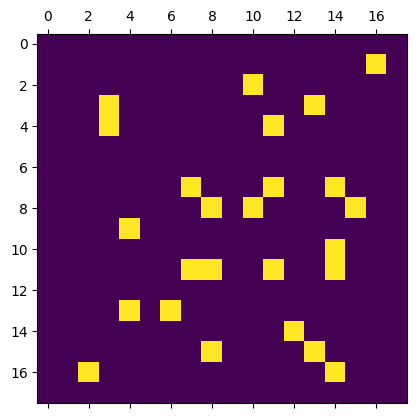

In [376]:

image = unif_random_config(0.1, 25)
image = np.pad(image, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))

y, x = image.shape

geo_found = []

for kernels in orbits:
    particle_no = kernels[0].sum()

    found_mat = np.zeros((y, x))

    orb = []

    for kernel in kernels:
        f = find_geometry(image, kernel, particle_no=particle_no)
        orb.append(f)
    geo_found.append(orb)

fig, ax = plt.subplots(1, 1)

ax.matshow(image)
print(image)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.75 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.75 0.   0.   0.   0.   0.   0.   0.   0.75 0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.   0.75 0.   0.
  0.75 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.   0.75 0.   0.   0.
  0.   0.75 0.   0.  ]
 [0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.


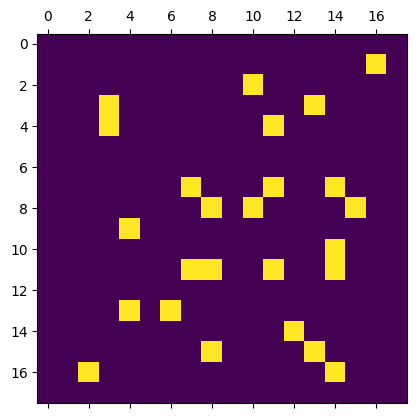

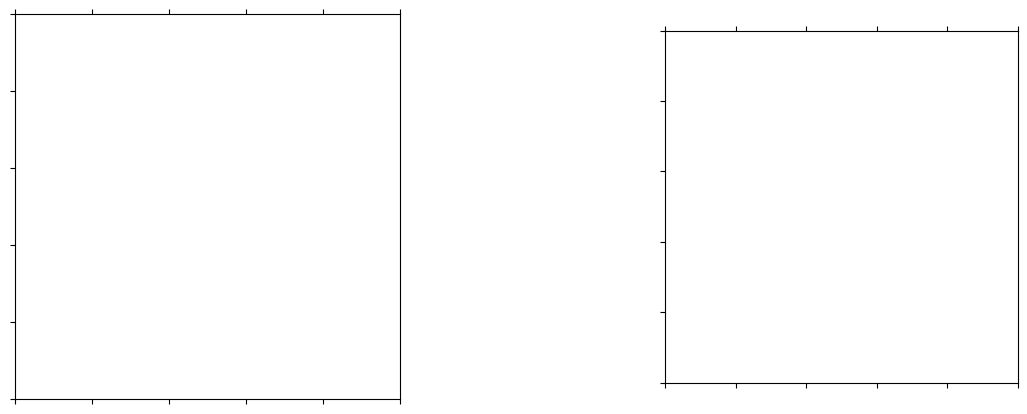

In [400]:
from matplotlib.animation import PillowWriter
metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=16, metadata=metadata)

#with writer.saving(fig, f'CONSTRUCTED_unif_ramsey_fringes.gif', 100):
fig, ax = plt.subplots(1, 1)

ax.matshow(image)

fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])
convax = fig.add_subplot(spec[0])
configax = fig.add_subplot(spec[1])
temp_img = image.copy()

with writer.saving(fig, f'CONVOLUTION.gif', 100):
    count = 0
    for i, m in zip(orbits, geo_found):
        if count == 73:
            print(i)
            print(m[0].sum())
            print(m[2].sum())
            print(np.nonzero(m[0]))
            print(np.transpose(np.nonzero(m[0])))
            print(m[0])
        convax.xaxis.set_tick_params(labelbottom=False)
        convax.yaxis.set_tick_params(labelleft=False)
        convax.set_xticks([])
        convax.set_yticks([])
        configax.xaxis.set_tick_params(labelbottom=False)
        configax.yaxis.set_tick_params(labelleft=False)
        configax.set_xticks([])
        configax.set_yticks([])

        config = i[-1]
        config = np.pad(config, 1, 'constant', constant_values=((0, 0), (0, 0)))
        colorbar = configax.matshow(config)
        colorbar.set_clim(0, 1)
        comap = convax.matshow(temp_img, cmap='gist_ncar')
        comap.set_clim(0, 1)
        
        
        writer.grab_frame()
        comp_img = temp_img.copy()

        yes = 0
        for o, p in zip(i, m):
            non_zero = np.nonzero(p)
            ty, tx = o.shape
            if ty == 1 and tx == 3:
                for uy, ux in np.transpose(non_zero):
                    temp_img[uy:uy + ty, ux - 1:ux + tx - 1] -= np.rot90(o, k=2)/4
                    yes = 1
            elif ty == 3 and tx == 1:
                for uy, ux in np.transpose(non_zero):
                    temp_img[uy - 1:uy + ty - 1, ux:ux + tx] -= np.rot90(o, k=2)/4
                    yes = 1
            elif ty == 1 and tx == 2:
                for uy, ux in np.transpose(non_zero):
                    temp_img[uy:uy + ty, ux - 1:ux + tx - 1] -= np.rot90(o, k=2)/4
                    yes = 1
            elif ty == 2 and tx == 1:
                for uy, ux in np.transpose(non_zero):
                    temp_img[uy - 1:uy + ty - 1, ux:ux + tx] -= np.rot90(o, k=2)/4
                    yes = 1

            
            else:
                for uy, ux in np.transpose(non_zero):
                    temp_img[uy - 1:uy + ty - 1, ux - 1:ux + tx - 1] -= np.rot90(o, k=2)/4
                    yes = 1
                    
            
        if yes == 1:
            configax.clear()
            colorbar = configax.matshow(config/2)
            colorbar.set_clim(0, 1)
            for i in range(20):
                writer.grab_frame()
            convax.clear()
            convax.xaxis.set_tick_params(labelbottom=False)
            convax.yaxis.set_tick_params(labelleft=False)
            convax.set_xticks([])
            convax.set_yticks([])
            comap = convax.matshow(temp_img, cmap='gist_ncar')
            comap.set_clim(0, 1)
            for i in range(20):
                writer.grab_frame()
            count += 1
        else:
            writer.grab_frame()
        
        convax.clear()
        configax.clear()

                    
print(temp_img)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


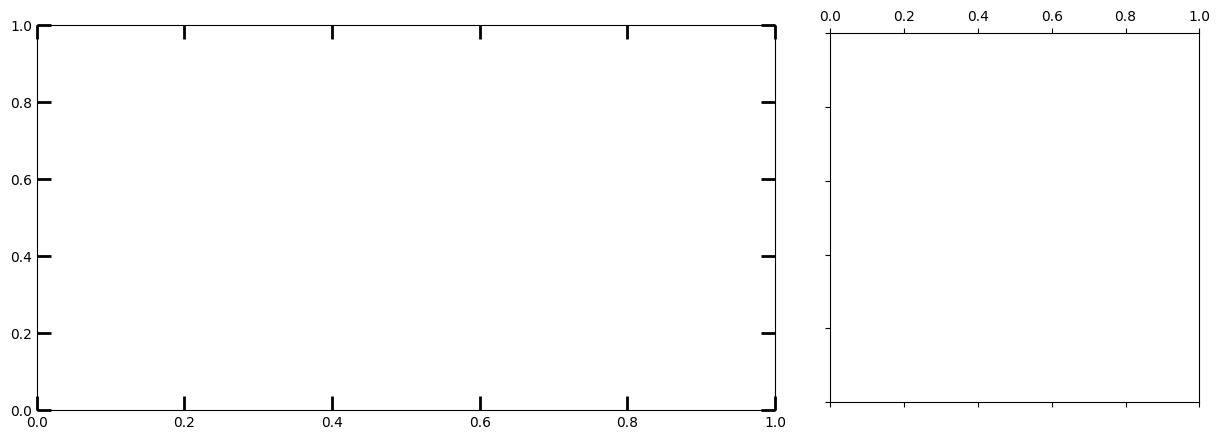

In [402]:
# animation
from matplotlib.animation import PillowWriter
fillings = np.concatenate((np.linspace(0.001, 0.35, 150), np.linspace(0.35, 1, 65)))

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=2, metadata=metadata)

#with writer.saving(fig, f'CONSTRUCTED_unif_ramsey_fringes.gif', 100):
    
fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1], wspace=0.1)
axes = fig.add_subplot(spec[0])
mataxis = fig.add_subplot(spec[1])


        
    #for i in range(5):
        #print(populations[:,1][100*i])



with writer.saving(fig, f'orbit_ramseys.gif', len(orbits)):
    for number in range(len(orbits[:-1])):
        config = orbits[number][-1]
        config = np.pad(config, 1, 'constant', constant_values=((-1, -1), (-1, -1)))
        cax = mataxis.matshow(config)
        cax.set_clim(0, 1)
        axes.plot(holds*(10**3), ALL_RAMSEYS[number])
        axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
        axes.set_xlabel('Free evolution time (ms)', fontsize=20)
        
        axes.minorticks_on()
        axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        
        axes.set_ylim([0, 1])
        
        
        # Hide X and Y axes label marks
        mataxis.xaxis.set_tick_params(labelbottom=False)
        mataxis.yaxis.set_tick_params(labelleft=False)
        
        # Hide X and Y axes tick marks
        mataxis.set_xticks([])
        mataxis.set_yticks([])
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        
        writer.grab_frame()
        
        mataxis.clear()
        axes.clear()
    
plt.show(block=False)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


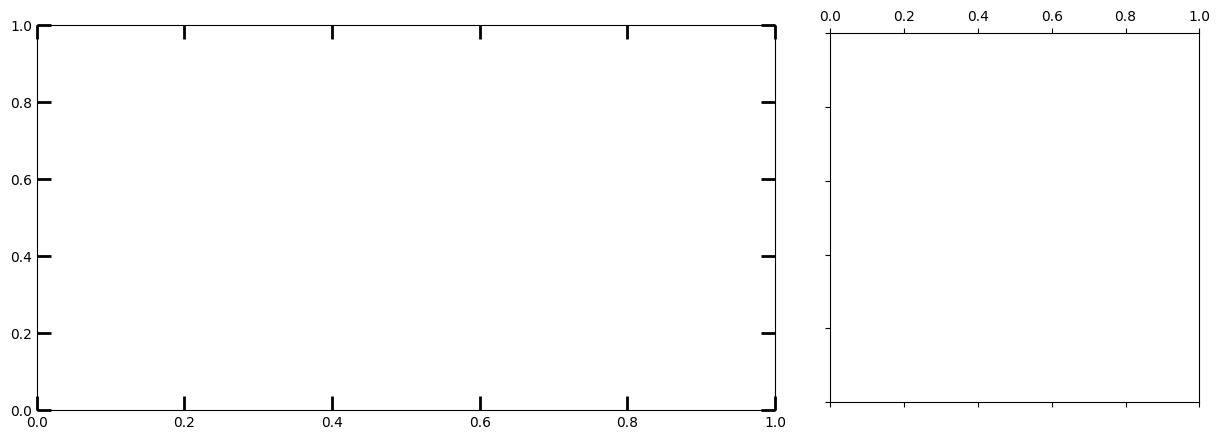

In [187]:
# animation
from matplotlib.animation import PillowWriter
fillings = np.concatenate((np.linspace(0.001, 0.35, 150), np.linspace(0.35, 1, 65)))

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=20, metadata=metadata)

#with writer.saving(fig, f'CONSTRUCTED_unif_ramsey_fringes.gif', 100):
    
fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1], wspace=0.1)
axes = fig.add_subplot(spec[0])
mataxis = fig.add_subplot(spec[1])


        
    #for i in range(5):
        #print(populations[:,1][100*i])



with writer.saving(fig, f'anisotropic_ramsey_triangle.gif', len(anisotropic)):
    for number in range(len(anisotropic)):
    
        cax = mataxis.matshow(orbits[index][-1])
        cax.set_clim(0, 1)
        axes.plot(holds*(10**3), anisotropic[number])
        axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
        axes.set_xlabel('Free evolution time (ms)', fontsize=20)
        
        axes.minorticks_on()
        axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        
        axes.set_ylim([0, 1])
        
        
        # Hide X and Y axes label marks
        mataxis.xaxis.set_tick_params(labelbottom=False)
        mataxis.yaxis.set_tick_params(labelleft=False)
        
        # Hide X and Y axes tick marks
        mataxis.set_xticks([])
        mataxis.set_yticks([])
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        
        writer.grab_frame()
        
        mataxis.clear()
        axes.clear()
    
plt.show(block=False)

In [68]:
# PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
PAIR = np.array(up_probabilities)


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/1131280173.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


TypeError: quantum_operator.tohamiltonian() got an unexpected keyword argument 'check_herm'

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


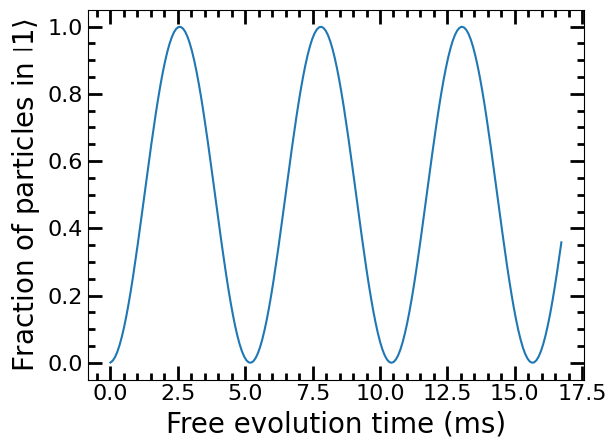

In [76]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [66]:
# DIAGONAL PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1
diag_seperation = np.sqrt(2)

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, diag_seperation, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
DIAG_PAIR = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/1131280173.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


TypeError: quantum_operator.tohamiltonian() got an unexpected keyword argument 'check_herm'

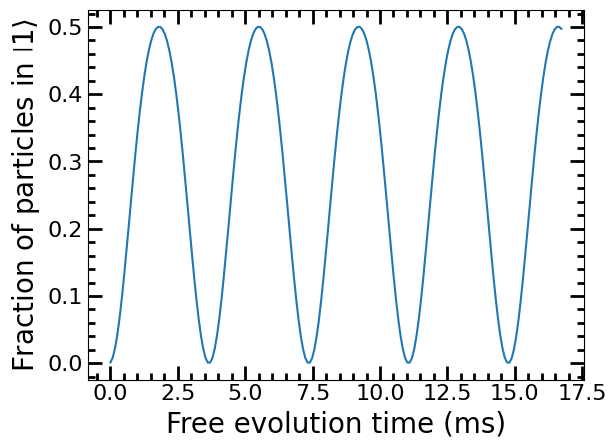

In [86]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), DIAG_PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [64]:
# SEPERATED PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1
sep_pair_seperation = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 5)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J/8, det, sep_pair_seperation, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
SEP_PAIR = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/1131280173.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


TypeError: quantum_operator.tohamiltonian() got an unexpected keyword argument 'check_herm'

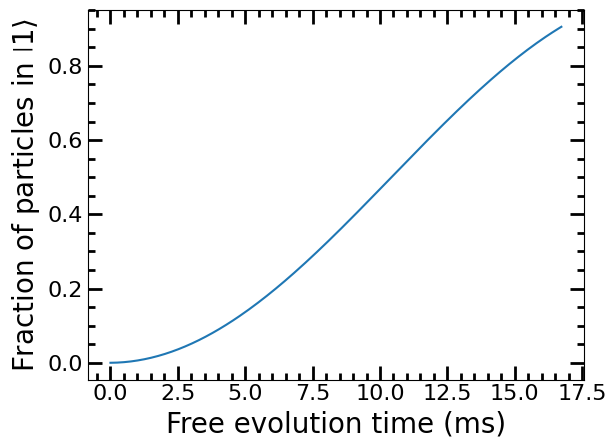

In [392]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), SEP_PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [86]:
# TRIANGLE

up_probabilities = []
progress = 0
particles = 3
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, 2, params, pulse_ramsey, theta=theta, phi=phi, Ly=2)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
TRIANGLE = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/1292662919.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


TypeError: quantum_operator.tohamiltonian() got an unexpected keyword argument 'verbose'

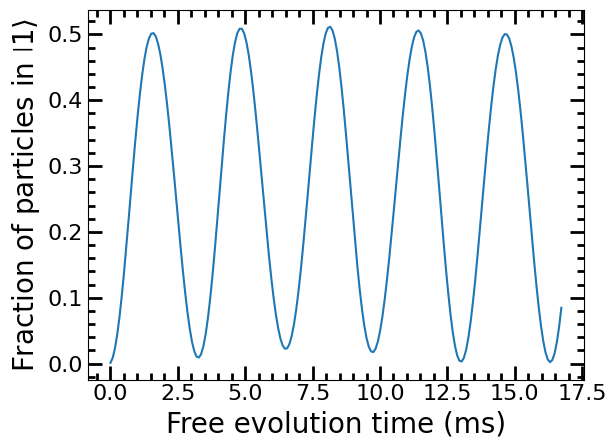

In [396]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), TRIANGLE)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [62]:
# CHAIN 3

up_probabilities = []
progress = 0
particles = 3
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
CHAIN_3 = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/1131280173.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


TypeError: quantum_operator.tohamiltonian() got an unexpected keyword argument 'check_herm'

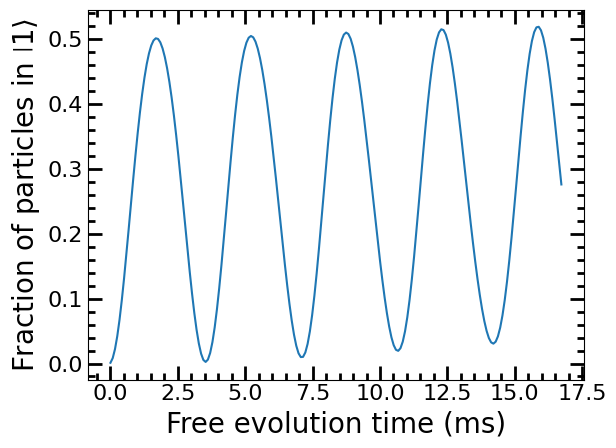

In [400]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), CHAIN_3)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [90]:
# CHAIN 4

up_probabilities = []
progress = 0
particles = 4
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
CHAIN_4 = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_23960/608318416.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermit

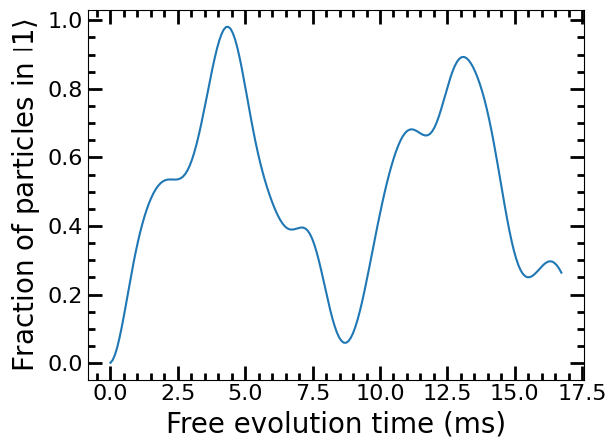

In [404]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), CHAIN_4)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [413]:
print(coefficients)
print(coefficients[1][0])

[[array([0.09831883, 0.28114286, 0.15244977]), 'Pairs'], [array([0.07803636, 0.20747506, 0.10057684]), 'Diagonal Pairs'], [array([0.08414337, 0.22261399, 0.10884819]), 'Seperated Pairs'], [array([0.14202449, 0.24655381, 0.03630905]), 'Triangles'], [array([0.1484297 , 0.28560682, 0.02106892]), 'Chain - 3'], [array([-0.30547858,  0.05971461, -2.15074999]), 'Chain - 4']]
[0.07803636 0.20747506 0.10057684]


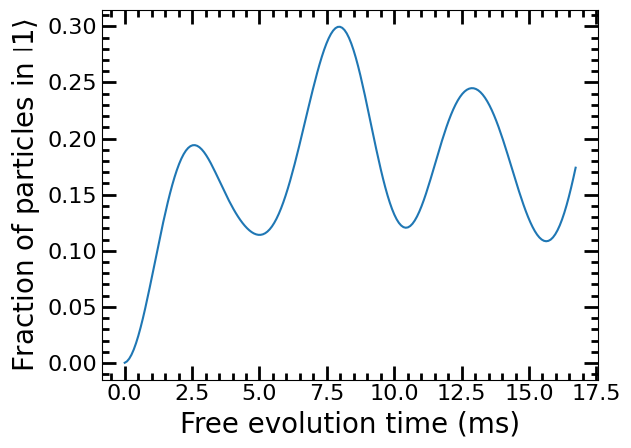

In [425]:
p, dp, sp, t, c3, c4 = gen_norm(coefficients[0][0]), gen_norm(coefficients[1][0]), gen_norm(coefficients[2][0]), gen_norm(coefficients[3][0]), gen_norm(coefficients[4][0]), gen_norm(coefficients[5][0])

lat_filling = 0.1

TOTAL = p(lat_filling)*PAIR + dp(lat_filling)*DIAG_PAIR + sp(lat_filling)*SEP_PAIR + t(lat_filling)*TRIANGLE + c3(lat_filling)*CHAIN_3 + c4(lat_filling)*CHAIN_4


fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), TOTAL)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [ ]:
# animation
from matplotlib.animation import PillowWriter

# set up 
metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

#create figure and axis 
fig, ax = plt.subplots()

with writer.saving(fig, f'filename.gif', 100): #100 might be the total number of frames
    #loop over each frame
    for i in fillings:
        
        #Plot on axes

        writer.grab_frame()

        #clear all axis
        ax.clear()


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


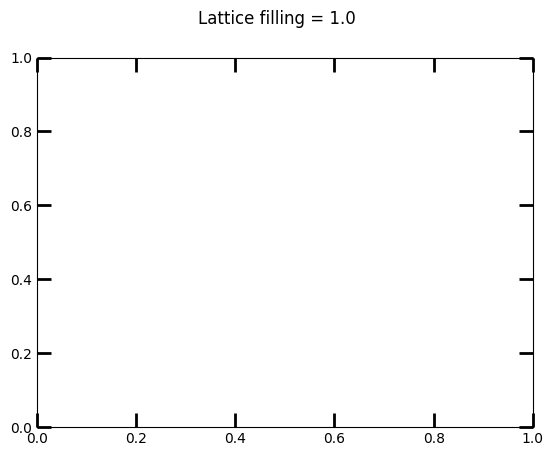

In [268]:
# animation
from matplotlib.animation import PillowWriter
fillings = np.concatenate((np.linspace(0.001, 0.35, 150), np.linspace(0.35, 1, 65)))

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()

with writer.saving(fig, f'ramsy_lat_fillings_simulation.gif', 100):
    for i in fillings:
        lat_filling = i
        TOTAL = np.zeros(intervals)
        for l, n in zip(model_coefficients , all_ramseys):
            model = gen_norm(l)
                #model = gen_norm(initial)
                #print(model(0.12))
            TOTAL = TOTAL + model(lat_filling)*np.array(n)
        
        ax.plot(holds*(10**3), TOTAL, color='black')
        
        #for i in range(5):
            #print(populations[:,1][100*i])


        yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        ax.set_yticks(yticks)
        ax.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
        ax.set_xlabel('Free evolution time (ms)', fontsize=20)
        fig.suptitle('Lattice filling = ' + str(i)[0:4])
    
        ax.minorticks_on()
        ax.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        
        
        writer.grab_frame()
        ax.clear()

In [451]:
def ensemble_Ramsey(samples, time, p_max, r_max, initial_state, N, J, det, ax, ay, params, pulse, theta=0, phi=0):
    results = []
    for i in range(samples):
        #r = random.randint(0, int(3000*r_max/4))/1000
        #p = p_max*(1 - (r/r_max)**2)
        #side_length = int(np.sqrt(N/p))+1
        #print(side_length)
        #side_length = 2
        side_length = int(np.sqrt(N/p_max))+1
        Hamiltonian = construct_H(N, J, det, ax, ay, side_length, params, pulse, theta=theta, phi=phi, Ly=side_length)
        populations = Hamiltonian.evolve(initial_state, 0, time)
        ups = sparse_up_prob(N, side_length, side_length, populations)
        results.append(ups[-1])
        #print('Sample ' + str(i) + ' completed')
    return sum(results)/samples

In [80]:


intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)
samples = 7

particles_per_sample = 12
J, det, ax, ay = 1200, 0, 1, 1
p_max, r_max = 0.054, 1000
theta, phi = 0, 0

initial_state = np.zeros(2**particles_per_sample)
initial_state[-1] = 1

up_probabilities = []
progress = 0
for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    times2 = np.linspace(0, 2*pulse_time + i, 3)
    params = [pulse_time, i, rabi_frequency]
    up_probabilities.append(ensemble_Ramsey(samples, times2, p_max, r_max, initial_state, particles_per_sample, J, det, ax, ay, params, pulse_ramsey, theta=theta, phi=phi))
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_60782/2187560175.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)
/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_60782/2187560175.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


1/200 Done
2/200 Done
3/200 Done
4/200 Done
5/200 Done
6/200 Done
7/200 Done
8/200 Done
9/200 Done
10/200 Done
11/200 Done
12/200 Done
13/200 Done
14/200 Done
15/200 Done
16/200 Done
17/200 Done
18/200 Done
19/200 Done
20/200 Done
21/200 Done
22/200 Done
23/200 Done
24/200 Done
25/200 Done
26/200 Done
27/200 Done
28/200 Done
29/200 Done
30/200 Done
31/200 Done
32/200 Done
33/200 Done
34/200 Done
35/200 Done
36/200 Done
37/200 Done
38/200 Done
39/200 Done
40/200 Done
41/200 Done
42/200 Done
43/200 Done
44/200 Done
45/200 Done
46/200 Done
47/200 Done
48/200 Done
49/200 Done
50/200 Done
51/200 Done
52/200 Done
53/200 Done
54/200 Done
55/200 Done
56/200 Done
57/200 Done
58/200 Done
59/200 Done
60/200 Done
61/200 Done
62/200 Done
63/200 Done
64/200 Done
65/200 Done
66/200 Done
67/200 Done
68/200 Done
69/200 Done
70/200 Done
71/200 Done
72/200 Done
73/200 Done
74/200 Done
75/200 Done
76/200 Done
77/200 Done
78/200 Done
79/200 Done
80/200 Done
81/200 Done
82/200 Done
83/200 Done
84/200 Done
8

In [336]:
with open('Fitted_freq_coefficients.pickle', 'rb') as handle:
    model_coefficients = np.array(pickle.load(handle))

with open('Orbit_Ramseys.pickle', 'rb') as handle:
    all_ramseys = np.array(pickle.load(handle))

print(np.array(all_ramseys).shape)
print(np.array(model_coefficients).shape)
print(np.array(up_probabilities).shape)

(84, 200)
(84, 3)
(200,)


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'all_avg' is not defined

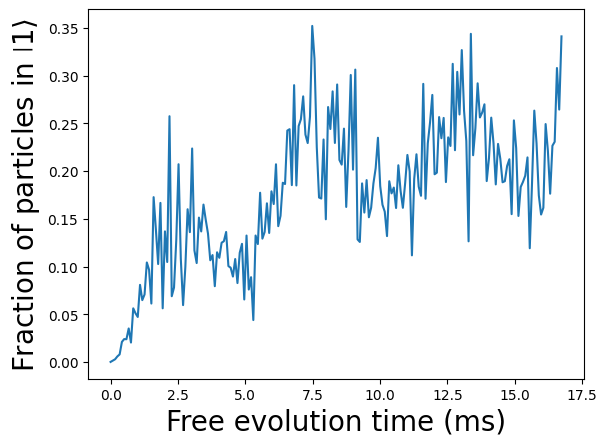

In [82]:
fig, axes = plt.subplots(1, 1)

intervals = 200
holds1 = np.linspace(0, 350 * pulse_time, intervals)

axes.plot(holds*(10**3), up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

lat_filling = p_max 
TOTAL = np.zeros(intervals)
for i, n in zip(all_avg[5] , all_ramseys):
    model = gen_fitted_curve(i)
        #model = gen_norm(initial)
        #print(model(0.12))
    #TOTAL = TOTAL + model(p_max)*np.array(n)
    TOTAL = TOTAL + i*np.array(n)

axes.plot(holds*(10**3), TOTAL, color='black')

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
yticks = np.linspace(0, 0.35, 8)
#axes.set_yticks(yticks) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'FULL_RESULTS_experimental_freq_{particles_per_sample}_Particle_Ramsey_{J}Hz_{p_max}_filling.png', bbox_inches='tight')
    
plt.show(block=False)

In [92]:
def gen_poly(symm, particles, empty_sites):
    def poly(lat_fil):
        return symm*((1 - lat_fil)**empty_sites)*(lat_fil**(particles - 1))
    return poly

[[0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[1 0 1]]
[[1 1]]
[[1 0]
 [0 1]]
[[1 0 0]
 [0 0 1]]


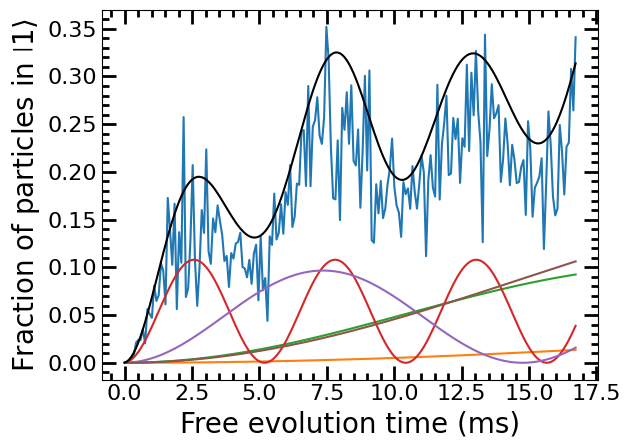

In [108]:
fig, axes = plt.subplots(1, 1)

intervals = 200
holds1 = np.linspace(0, 350 * pulse_time, intervals)

axes.plot(holds*(10**3), up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

lat_filling = p_max 
TOTAL = np.zeros(intervals)
for i, n in zip(orbits , all_ramseys):
    
    symm = len(i)
    particles = i[0].sum()
    h, o = i[0].shape
    empty_sites = h*o - particles
    
    model = gen_poly(symm, particles, empty_sites)
    coef = model(lat_filling)
        #model = gen_norm(initial)
        #print(model(0.12))
    #TOTAL = TOTAL + model(p_max)*np.array(n)

    if coef >= 0.05:
        axes.plot(holds*(10**3), coef*np.array(n))
        print(i[0])
    TOTAL = TOTAL + coef*np.array(n)

axes.plot(holds*(10**3), TOTAL, color='black')

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
yticks = np.linspace(0, 0.35, 8)
#axes.set_yticks(yticks) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'new_freq_{particles_per_sample}_Particle_Ramsey_{J}Hz_{p_max}_filling.png', bbox_inches='tight')
    
plt.show(block=False)

In [477]:
print(coefficients)

[[array([0.09831883, 0.28114286, 0.15244977]), 'Pairs'], [array([0.07803636, 0.20747506, 0.10057684]), 'Diagonal Pairs'], [array([0.08414337, 0.22261399, 0.10884819]), 'Seperated Pairs'], [array([0.14202449, 0.24655381, 0.03630905]), 'Triangles'], [array([0.1484297 , 0.28560682, 0.02106892]), 'Chain - 3'], [array([-0.30547858,  0.05971461, -2.15074999]), 'Chain - 4']]
